# Interaction Module 

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()

### ... qualitative module comparison

In [25]:
import itertools
import mantrap
import torch


env = mantrap.environment.Trajectron(ego_position=torch.zeros(2), ego_velocity=torch.zeros(2))
env.add_ado(position=torch.tensor([5, 5]), velocity=torch.tensor([0, -1]))

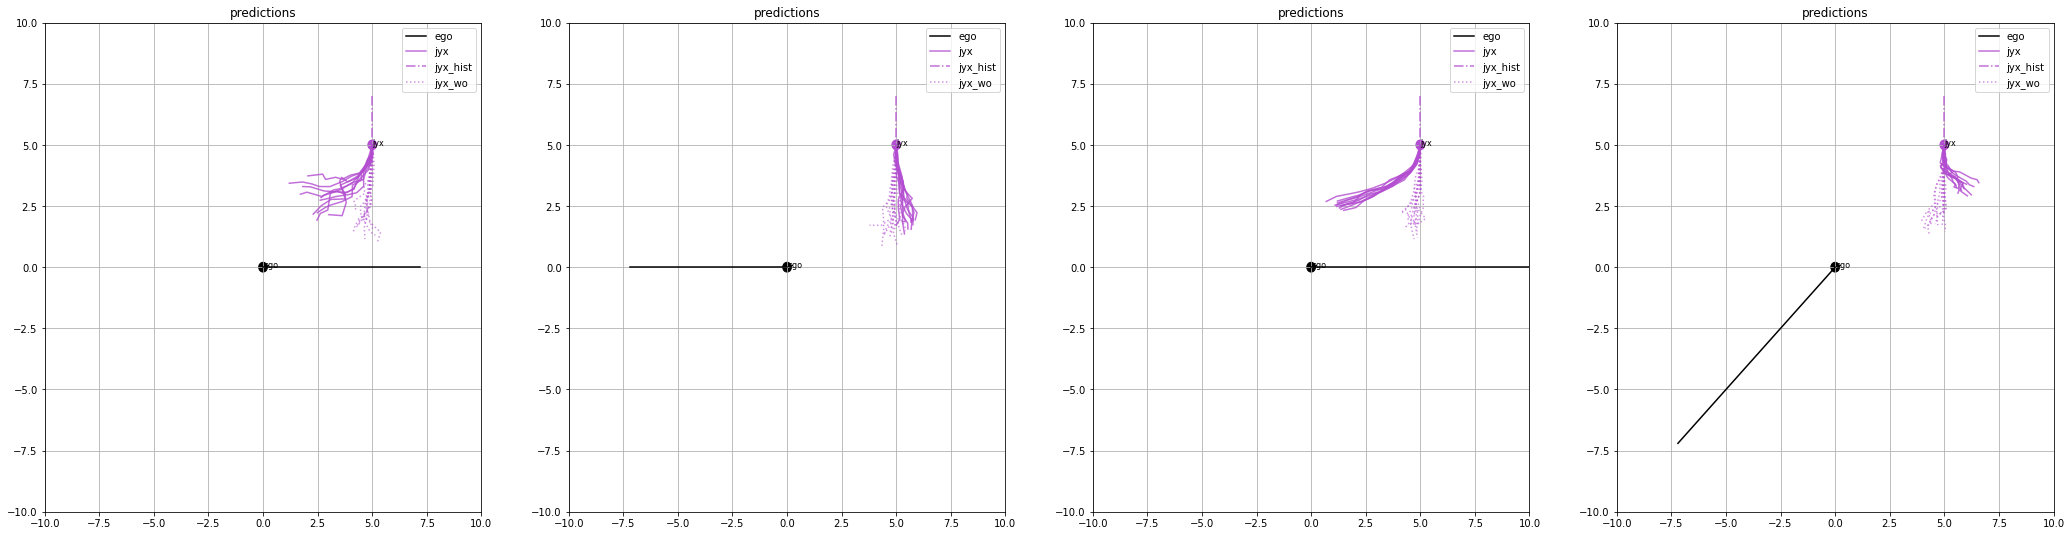

In [26]:
t_horizon = 10
controls_list = [torch.stack([torch.tensor([1, 0])] * t_horizon).float(), 
                 torch.stack([torch.tensor([-1, 0])] * t_horizon).float(), 
                 torch.stack([torch.tensor([2, 0])] * t_horizon).float(), 
                 torch.stack([torch.tensor([-1, -1])] * t_horizon).float()]

fig, ax = plt.subplots(1, len(controls_list), figsize=(len(controls_list) * 9, 9))
for i, ego_controls in enumerate(controls_list):
    env.visualize_prediction_w_controls(ego_controls, ax=ax[i], legend=True)
plt.show()

### quantitative module comparison

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()

import mantrap
import mantrap_evaluation
import pandas as pd
import torch


env, goal, _ = mantrap_evaluation.scenarios.custom_avoid(mantrap.environment.PotentialFieldEnvironment)
modules = {"probability": mantrap.modules.InteractionProbabilityModule, 
           "diff_pos": mantrap.modules.baselines.InteractionPositionModule, 
           "diff_vel": mantrap.modules.baselines.InteractionVelocityModule, 
           "diff_acc": mantrap.modules.baselines.InteractionAccelerationModule, 
           "none": None}

eval_df = pd.DataFrame()
num_eval = len(modules.keys())
fig, ax = plt.subplots(1, num_eval, figsize=(num_eval * 9, 9))
for i, (label, module) in enumerate(modules.items()): 
    modules_hard = mantrap.solver.IPOPTSolver.module_hard()
    solver_modules = modules_hard + [module] if module is not None else modules_hard 
    solver = mantrap.solver.IPOPTSolver(env=env, goal=goal, modules=solver_modules)
    
    eval_df_k, ego_trajs, ado_trajs = mantrap_evaluation.evaluate(solver, label=label, num_tests=1)
    eval_df = eval_df.append(eval_df_k)
    mantrap.visualization.visualize_prediction(env=env, 
                                               ego_planned=torch.mean(ego_trajs, dim=0), 
                                               ado_planned=ado_trajs, 
                                               ego_goal=solver.goal, legend=True, ax=ax[i])

In [2]:
eval_df

,ado_effort,directness,ego_effort,extra_time,final_distance,minimal_distance,runtime[s]
probability,0.313570,0.926586,0.787462,0.8,0.392136,1.440959,1.449936
diff_pos,0.313567,0.998264,0.321904,0.0,0.237884,0.947395,0.707022
diff_vel,0.313570,0.989109,0.510499,0.0,0.256214,1.163663,0.779153
diff_acc,0.313572,0.987298,0.551422,0.0,0.274714,1.246176,0.646119
none,0.313571,1.000000,0.273809,0.0,0.233409,1.084038,0.047593


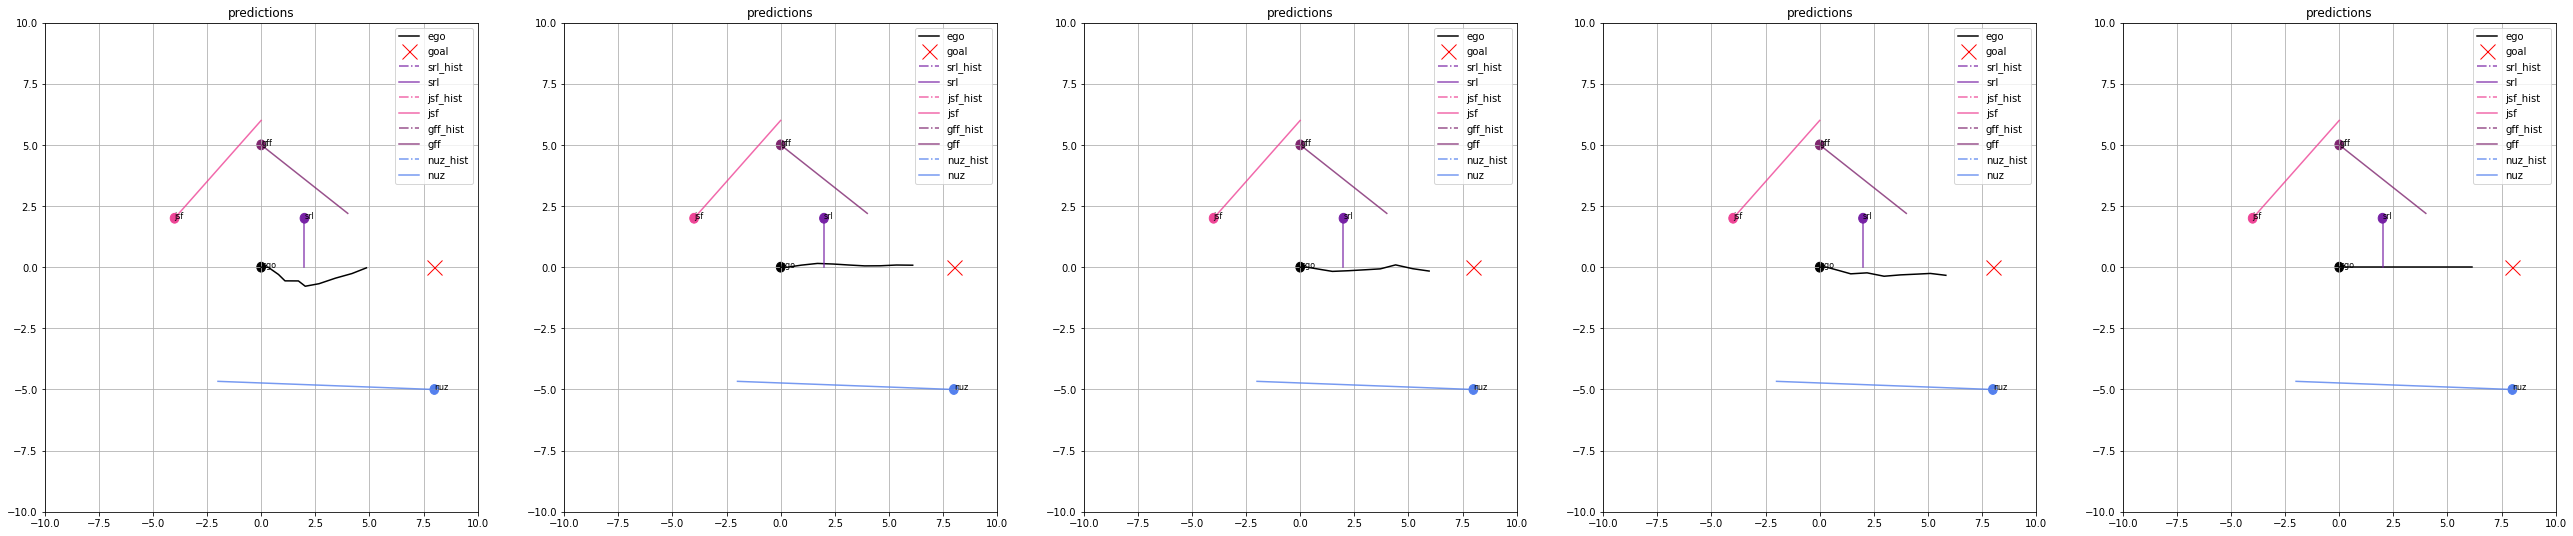

In [4]:
plt.show()